# What this notebook does:

This notebook has code to plot various marker gene expression plots: This includes Fig 2B, 2K and S3A-H.

# Set up

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as pl, scipy.sparse as ssp
import scanpy as sc,scanpy.external as sce
import sys
sys.path.append('../../helper_functions/')
import helper_functions_py3 as hf

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100)  # low dpi (dots per inch) yields small inline figures

import random
import scipy.stats  as ss
import statsmodels.stats.multitest as multitest
from matplotlib.patches import Rectangle
import seaborn as sn
from sklearn.neighbors import NearestNeighbors



# Load data

In [2]:
# load indrops data
# update this with the path where your anndata objects are stored !!
anndata_path = '../../data/anndata_objects/'
adata = sc.read_h5ad('../../data/anndata_objects/all_indrops_data.h5ad')

# Define functions

## Find knn

In [3]:
# find k nearest neighbors for each cell:

def find_knn(adata, neighbors = 10):
    
    # filter genes:
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_genes(adata, min_counts=6)
    
    # normalized data:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.layers['raw_counts'] = adata.X.copy()
    
    # log transform data:
    sc.pp.log1p(adata)

    # identify highly variable genes:
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)

    # scale data:
    sc.pp.scale(adata)

    # find top 50 PCs:
    sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
    
    # find nearest neighbors:
    E = adata.obsm['X_pca']

    adata_neigbhors = NearestNeighbors(n_neighbors=neighbors, metric='euclidean').fit(E)
    knn = adata_neigbhors.kneighbors(E)[1]
    
    return knn


## Find gene expression

In [4]:
# get z-scores for each set of marker genes 

def gene_exp_condition(adata, treatment, gene_list, cell_gene_dict):

    # subset adata:
    adata_subset = adata[adata.obs.condition == treatment].copy()
    sc.pp.normalize_per_cell(adata_subset, counts_per_cell_after=1e4)
    adata_subset = adata_subset[:,gene_list].copy()

    # log transform data
    sc.pp.log1p(adata_subset)

    # scale data
    sc.pp.scale(adata_subset)

    # take mean expression of neighbors
    mean_exp = adata_subset.X[find_knn(adata[adata.obs.condition == treatment].copy())].mean(axis=1)
    mean_exp = pd.DataFrame(mean_exp)
    mean_exp.columns = gene_list

    # find z_celltype
    mean_z = pd.DataFrame(np.zeros((mean_exp.shape[0],(len(cell_gene_dict.keys())) )))
    mean_z.columns = cell_gene_dict.keys()

    return mean_exp, mean_z


# get z-scores for each set of marker genes 

def gene_exp(adata, gene_list, cell_gene_dict):

    # subset adata:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata_subset = adata[:,gene_list].copy()

    # log transform data
    sc.pp.log1p(adata_subset)

    # scale data
    sc.pp.scale(adata_subset)

    # take mean expression of neighbors
    mean_exp = adata_subset.X[find_knn(adata)].mean(axis=1)
    mean_exp = pd.DataFrame(mean_exp)
    mean_exp.columns = gene_list

    # find z_celltype
    mean_z = pd.DataFrame(np.zeros((mean_exp.shape[0],(len(cell_gene_dict.keys())) )))
    mean_z.columns = cell_gene_dict.keys()
    
    for genesubset in cell_gene_dict.keys():
        mean_z[genesubset] = np.array(mean_exp[cell_gene_dict[genesubset]].mean(axis=1))

    return mean_exp, mean_z

# plot marker gene score:
def plot_z(z_data, genesubset, celltypes, subset, treatment):

    pl.hist(z_data[genesubset][~np.array(adata.obs['cell_states'].isin(celltypes))], alpha = 0.4, density = True)
    pl.hist(z_data[genesubset][np.array(adata.obs['cell_states'].isin(celltypes))], alpha = 0.4, density = True)
    
    if subset == True:
        z_sub = z_data[np.array(adata.obs.condition == treatment)]
        adata_sub = adata[adata.obs.condition==treatment].copy()
        pl.hist(z_sub[genesubset][np.array(adata_sub.obs['cell_states'].isin(celltypes))],
                alpha = 0.4, density = True)
    pl.xticks(fontsize = 19, fontname = 'Arial')
    pl.yticks(fontsize = 19, fontname = 'Arial')

    sn.despine()
    pl.grid(False)

In [5]:
# markers per cell type:

basal_shortlist = ['KRT5', 'KRT13','S100A2','KRT14', 'CSTA']
multiciliated_shortlist = [ 'FOXJ1','C9orf24','RSPH1', 'TPPP3', 'SNTN' ]
secretory_shortlist = ['MUC5B', 'SCGB3A1', 'VMO1', 'BPIFA1', 'BPIFB1']
ionocyte_shorlist = np.array(['FOXI1','TMPRSS11E', 'STAP1', 'CFTR', 'PDE1C'])
pnec_shorlist = np.array(['ASCL1','SST', 'GRP', 'CALCA', 'CHGA'])
tuft_shortlist = np.array(['POU2F3', 'LRMP', 'NREP', 'CRYM', 'HOTAIRM1'])
rare_shortlist = ['FOXI1', 'CFTR', 'NREP', 'CRYM', 'ASCL1','GRP']

# combine all markers:
markergene_list = np.hstack([basal_shortlist,secretory_shortlist,multiciliated_shortlist,
                             ionocyte_shorlist, tuft_shortlist, pnec_shorlist])

In [6]:
# cell type: marker genes dictionary:

celltype_genes = {'Basal': basal_shortlist, 
                  'Secretory': secretory_shortlist, 
                  'Multiciliated': multiciliated_shortlist, 
                  'Ionocyte': ionocyte_shorlist, 'Tuft':tuft_shortlist, 'PNEC': pnec_shorlist}

In [7]:
# find expression of marker genes and also z-score for each cell type
gene_exp_all, z_all = gene_exp(adata, markergene_list, celltype_genes)


normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
filtered out 6937 genes that are detected in less than 3 cells
filtered out 525 genes that are detected in less than 6 counts
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:43)


## Plot marker score

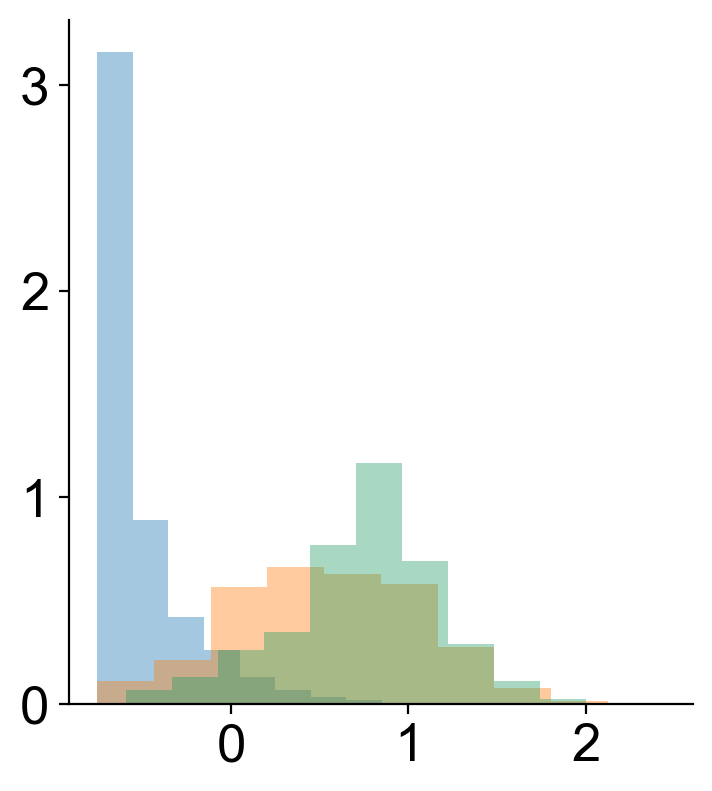

In [8]:
# basal score:

pl.figure(figsize = (4,4.5))
plot_z(z_all, genesubset = 'Basal', celltypes = ['Basal'], subset=True, treatment ='None')
pl.yticks([0,1,2,3])
pl.savefig("../../figures/FigS3A_basal_marker_histogram.png", bbox_inches='tight', dpi = 300)


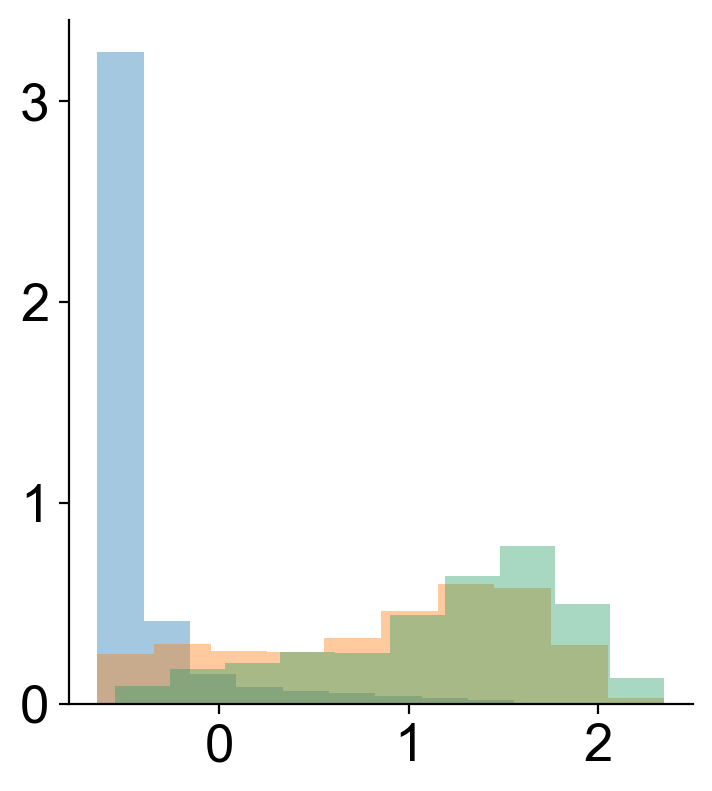

In [9]:
# secretory score:

pl.figure(figsize = (4,4.5))

plot_z(z_all, genesubset = 'Secretory',celltypes = ['Club','Goblet'], subset=True, treatment ='None')
pl.yticks([0,1,2,3])

pl.savefig("../../figures/FigS3A_club_marker_histogram.png", bbox_inches='tight', dpi = 300)


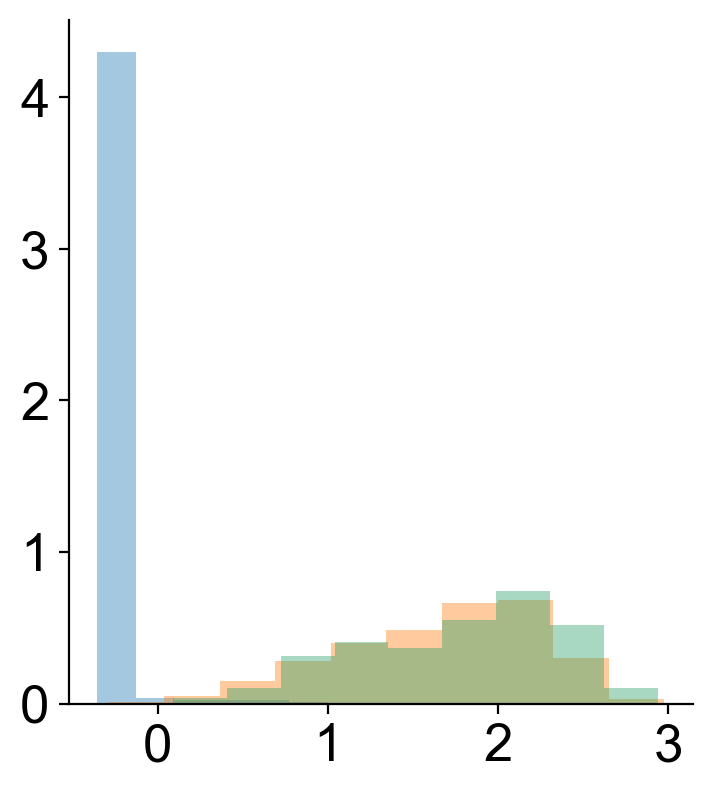

In [10]:
# multiciliated score:

pl.figure(figsize = (4,4.5))

plot_z(z_all,genesubset = 'Multiciliated', celltypes = ['Multiciliated'], subset=True, treatment ='None')
pl.savefig("../../figures/FigS3A_multiciliated_marker_histogram.png", bbox_inches='tight', dpi = 300)

# cutoff: z=0

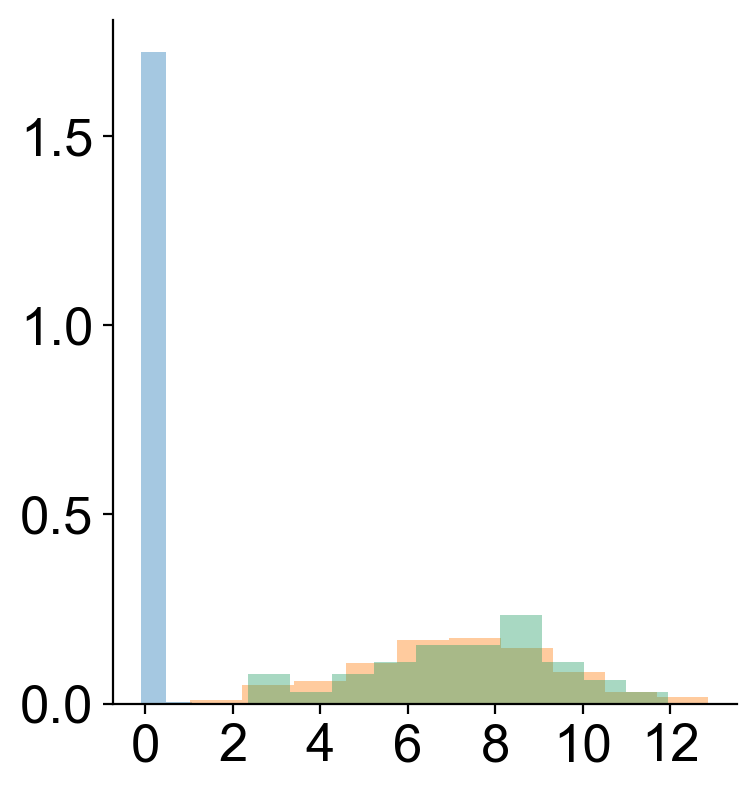

In [11]:
# ionocyte score:

pl.figure(figsize = (4,4.5))

plot_z(z_all,genesubset = 'Ionocyte', celltypes = ['Ionocyte'], subset=True, treatment ='None')
bla = pl.xticks([0,2,4,6,8,10,12], fontname = 'Arial', fontsize = 19)
bla = pl.yticks([0,0.5,1,1.5], fontname = 'Arial', fontsize = 19)

pl.savefig("../../figures/FigS3A_ionocyte_marker_histogram.png", bbox_inches='tight', dpi = 300)

# cutoff: z=1

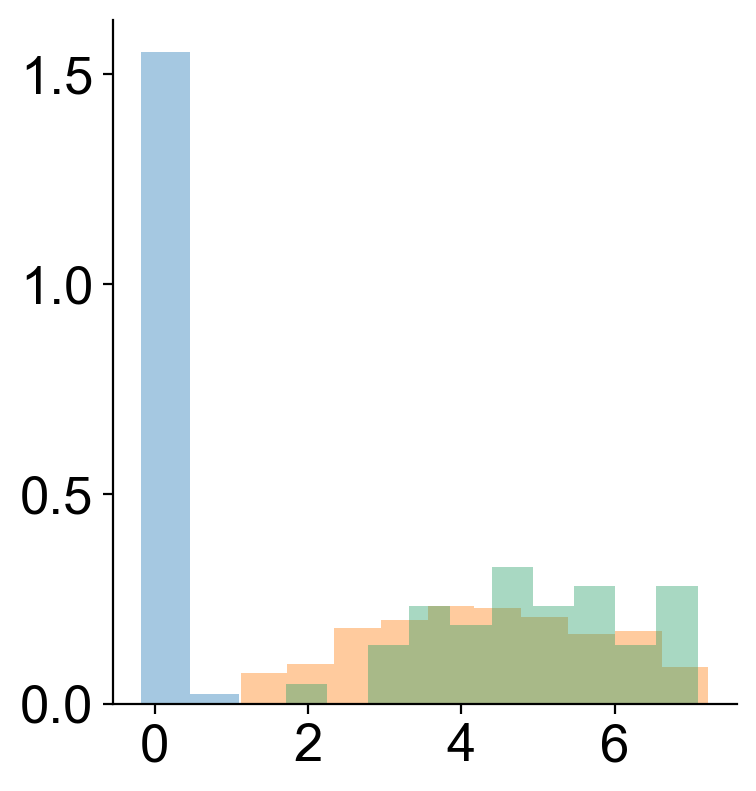

In [12]:
# tuft score:

pl.figure(figsize = (4,4.5))

plot_z(z_all, genesubset = 'Tuft', celltypes = ['Tuft'], subset=True, treatment ='None')
bla = pl.yticks([0,0.5,1,1.5], fontname = 'Arial', fontsize = 19)

pl.savefig("../../figures/FigS3A_tuft_marker_histogram.png", bbox_inches='tight', dpi = 300)

#cutoff = 1

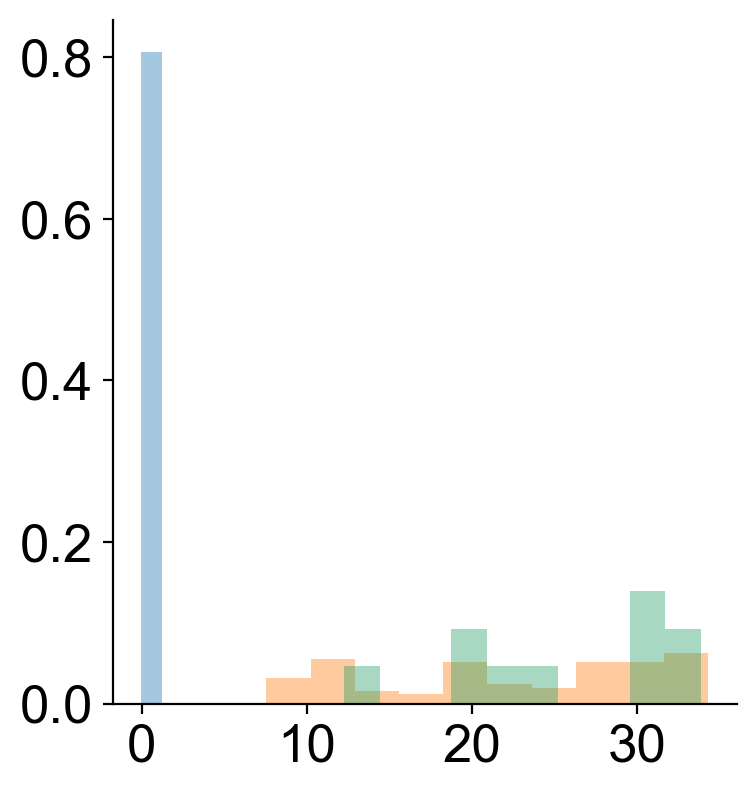

In [13]:
# PNEC score:

pl.figure(figsize = (4,4.5))

plot_z(z_all, genesubset = 'PNEC',celltypes = ['PNEC'], subset=True, treatment ='None')
pl.savefig("../../figures/FigS3A_pnec_marker_histogram.png", bbox_inches='tight', dpi = 300)

# cutoff z = 5

# Make heatmap of markers

## Find expression of markers by combing some states (like rare cells)

In [14]:
# reload the data:
adata = sc.read_h5ad('../../data/anndata_objects/all_indrops_data.h5ad')

In [15]:
# marker gene list after combining markers for rare cells:
markergene_list2 = np.hstack([basal_shortlist,
                              secretory_shortlist, 
                              multiciliated_shortlist,
                             rare_shortlist])

In [16]:
# dictionary for gene subsets for specific cell states:
celltype_genes2 = {'Basal': basal_shortlist, 
                  'Secretory': secretory_shortlist, 
                  'Multiciliated': multiciliated_shortlist, 
                   'Rare': rare_shortlist}

In [17]:
# find gene expression and z-score
gene_exp_all2, z_all2 = gene_exp(adata, markergene_list2, celltype_genes2)
                               

normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
filtered out 6937 genes that are detected in less than 3 cells
filtered out 525 genes that are detected in less than 6 counts
normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:11)


## Order cells for plotting

In [18]:
# combine rare cells as one category and secretory cells as a single category:
cell_states_combined = np.array(adata.obs.cell_states)
for i, states in enumerate(np.array(adata.obs.cell_states)):
    if states == 'Ionocyte':
        cell_states_combined[i] = 'Rare'
    if states == 'Tuft':
        cell_states_combined[i] = 'Rare'
    if states == 'PNEC':
        cell_states_combined[i] = 'Rare'
    if states == 'Goblet':
        cell_states_combined[i] = 'Secretory'    
    if states == 'Club':
        cell_states_combined[i] = 'Secretory'

In [19]:
# order cells by cell states: 

# take cells of particular cell types and order them based on marker gene score 
state_list2 = ['Basal', 'Secretory', 'Multiciliated', 'Rare']

exp_markers_dict2 = {}
z_dict2 = {}

for types in state_list2:
    exp_markers_dict2[types] = gene_exp_all2.iloc[cell_states_combined== types,:]
    
for types in state_list2:
    z_dict2[types] = z_all2.iloc[cell_states_combined == types,:]



In [20]:
# within a cell state, order by decreasing order of z-score for the particular cell state:

ix_basal_order = z_dict2['Basal'].sort_values(by = 'Basal', ascending = False).index
ix_secretory_order = z_dict2['Secretory'].sort_values(by = 'Secretory', ascending = False).index
ix_multiciliated_order = z_dict2['Multiciliated'].sort_values(by = 'Multiciliated', ascending = False).index
ix_rare_order = z_dict2['Rare'].sort_values(by = 'Rare', ascending = False).index

exp_markers_ordered2 = pd.concat([exp_markers_dict2['Basal'].loc[ix_basal_order,:], 
                                exp_markers_dict2['Secretory'].loc[ix_secretory_order,:],

                                exp_markers_dict2['Multiciliated'].loc[ix_multiciliated_order,:],
                                exp_markers_dict2['Rare'].loc[ix_rare_order,:]])

In [21]:
#  put ticks at the end of each cell state:

y1 = exp_markers_dict2['Basal'].shape[0]
y2 = y1 + exp_markers_dict2['Secretory'].shape[0]
y3 = y2 + exp_markers_dict2['Multiciliated'].shape[0]
y4 = y3 + exp_markers_dict2['Rare'].shape[0]

yticks_for_heatmap = np.array([y1,y2,y3])
                               
                               
                               

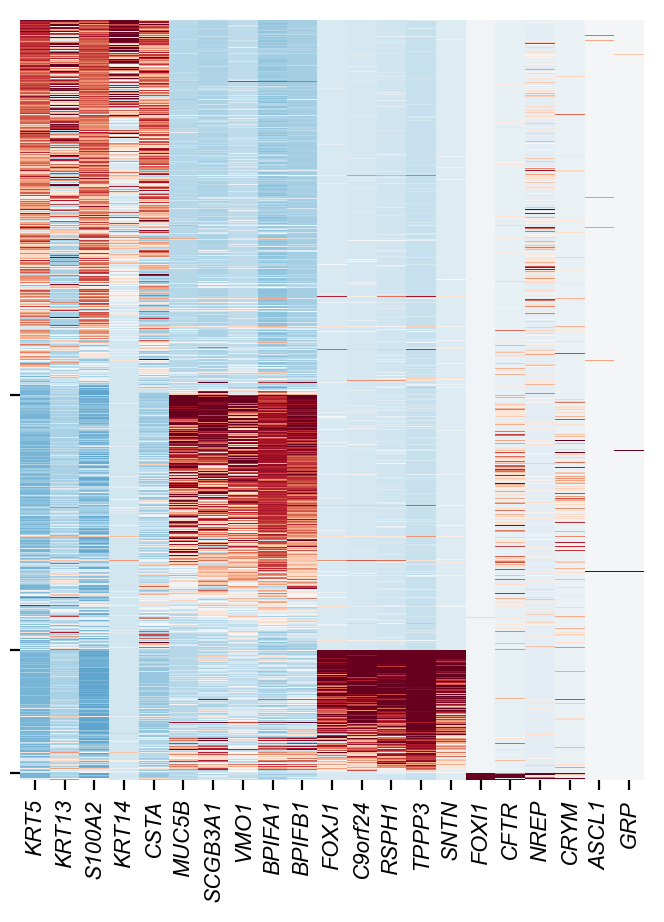

In [22]:
# plot marker genes

pl.figure(figsize = (4,5))
sn.heatmap(exp_markers_ordered2, vmax = 2, vmin = -2, cmap = 'RdBu_r',
           xticklabels=markergene_list2, yticklabels=[], cbar = [], rasterized= True)

bli = pl.xticks(fontsize = 8, fontname = 'Arial', style = 'italic')
bla = pl.yticks(yticks_for_heatmap)


# Label transitional cell states


## Transitional secretory cells:

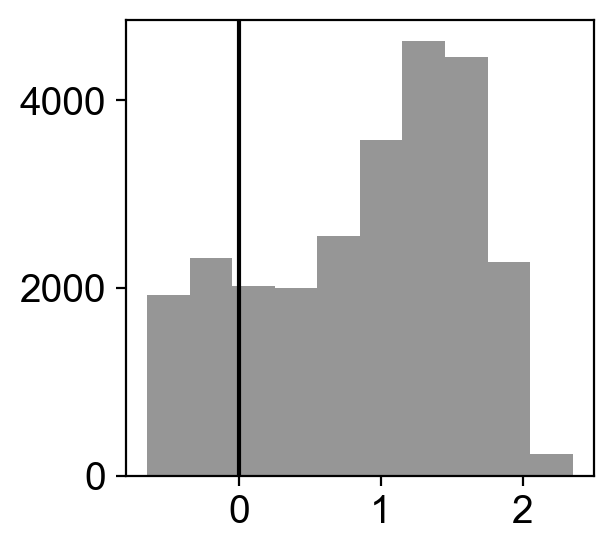

In [23]:
# histogram of secretory z-scores of secretory cells
pl.figure(figsize = (3,3))
pl.hist(z_dict2['Secretory']['Secretory'], rasterized = True, color = '#969696')
pl.grid(False)
pl.axvline(x=0, color = 'black')
bla = pl.yticks([0,2000,4000])
pl.savefig("../../figures/FigS3B_revisions_sec_z_hist.pdf", bbox_inches='tight', dpi = 300)

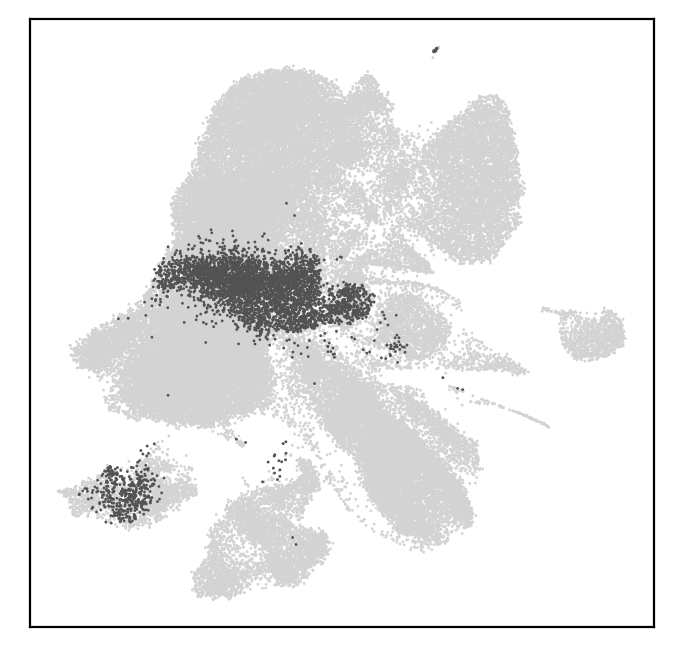

In [24]:
# umap of secretory cells with z<0: 
umap_sec_low = (adata[z_dict2['Secretory'].loc[z_dict2['Secretory']['Secretory']<0].index]).obsm['X_umap']
umap_sec_high = (adata[z_dict2['Secretory'].loc[z_dict2['Secretory']['Secretory']>0].index]).obsm['X_umap']

# umap of all cells:
umap_all = adata.obsm['X_umap']

pl.scatter(umap_all[:,0], umap_all[:,1], color = 'lightgrey', s=1, edgecolor = 'none', rasterized = True)
pl.scatter(umap_sec_low[:,0], umap_sec_low[:,1], s=1, color = '#525252', edgecolor = 'none', rasterized = True)

pl.grid(False)
pl.xticks([])
pl.yticks([])

pl.savefig("../../figures/FigS3C_revisions_sec-low_cells.pdf", bbox_inches='tight', dpi = 300)



### plot expression of marker genes:


In [25]:
# reload the data:
adata = sc.read_h5ad('../../data/anndata_objects/all_indrops_data.h5ad')

# counts normalize:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform data:
sc.pp.log1p(adata)


normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [26]:

# subset cells of different cell states for plotting gene expression
ix_sec_low = z_dict2['Secretory'][z_dict2['Secretory']['Secretory']<0].index
ix_sec_high = z_dict2['Secretory'][z_dict2['Secretory']['Secretory']>0].index

ix_sec = z_dict2['Secretory'].index
ix_basal = z_dict2['Basal'].index
ix_mcc = z_dict2['Multiciliated'].index
ix_rare = z_dict2['Rare'].index



In [27]:
# gene expression of secretory genes in basal, sec-high and sec-low cells:

secretory_shortlist2=['MUC5B','SCGB3A1','VMO1', 'BPIFA1', 'BPIFB1']

adata_temp = adata[:,secretory_shortlist2].copy()

basal_exp = pd.DataFrame([adata_temp[ix_basal].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_basal.shape[0], dtype = object) for gene in secretory_shortlist2]),
                          'Basal'*np.ones(len(secretory_shortlist2)*ix_basal.shape[0], dtype = object)])

basal_exp = basal_exp.T

sec_low_exp = pd.DataFrame([adata_temp[ix_sec_low].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_sec_low.shape[0], dtype = object) for gene in secretory_shortlist2]),
                          'Secretory transitional'*np.ones(len(secretory_shortlist2)*ix_sec_low.shape[0], dtype = object)])
sec_low_exp = sec_low_exp.T

sec_high_exp = pd.DataFrame([adata_temp[ix_sec_high].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_sec_high.shape[0], dtype = object) for gene in secretory_shortlist2]),
                          'Secretory mature'*np.ones(len(secretory_shortlist2)*ix_sec_high.shape[0], dtype = object)])
sec_high_exp = sec_high_exp.T

sec_exp_pd = pd.concat([basal_exp, sec_low_exp, sec_high_exp])
sec_exp_pd.columns = ['Exp', 'Genes', 'Cell state']

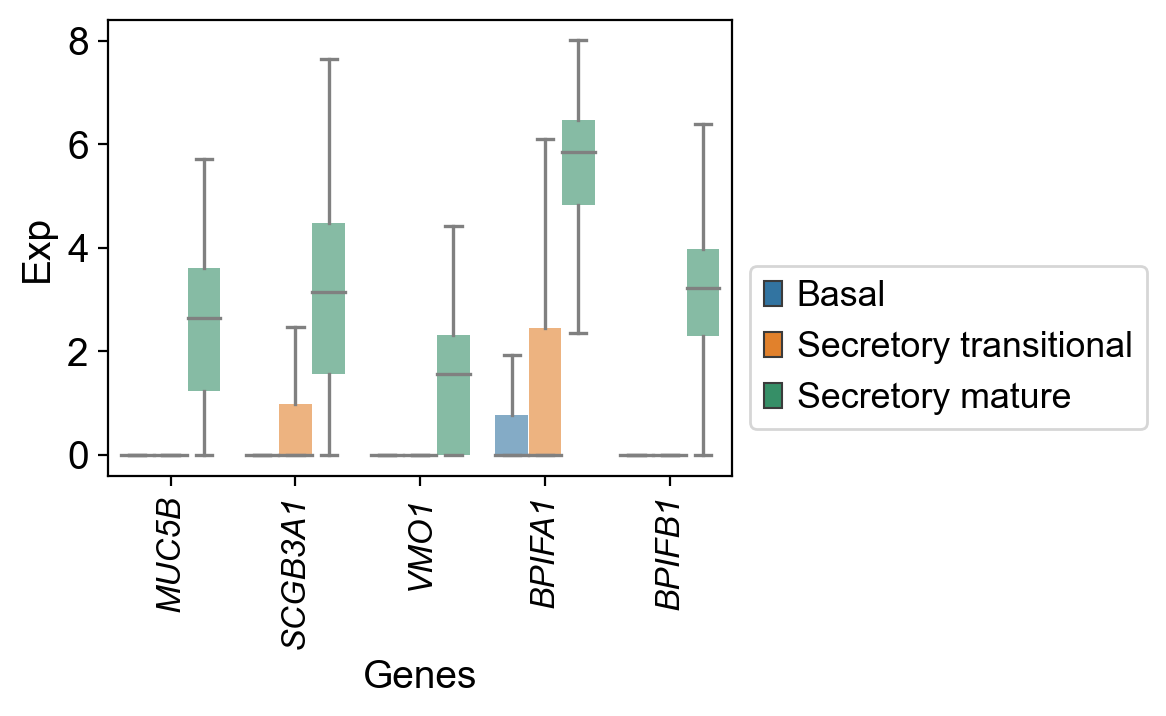

In [28]:
# plot expression:

pl.figure(figsize = (4,3))
sn.boxplot(data = sec_exp_pd, y='Exp', x = 'Genes', hue = 'Cell state', showfliers=False,
           boxprops=dict(alpha=.6, linewidth = 0),
           whiskerprops=dict(linestyle='-', linewidth=1.2, color='grey'),
           capprops=dict(linestyle='-', linewidth=1.2, color='grey'),
            medianprops=dict(linestyle='-', linewidth=1.2, color='grey')
          )
pl.xticks(rotation = 90,fontstyle = 'italic', fontsize=12)
pl.grid(False)
pl.legend(bbox_to_anchor=(1, 0., 0.5, 0.5))

pl.savefig("../../figures/FigS3D_sec_marker_genes.pdf", bbox_inches='tight', dpi = 300)


In [29]:
# gene expression of basal genes in basal, sec-high and sec-low cells:

basal_shortlist2 = basal_shortlist+['TP63']
adata_temp2 = adata[:,basal_shortlist2].copy()

basal_exp2 = pd.DataFrame([adata_temp2[ix_basal].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_basal.shape[0], dtype = object) for gene in basal_shortlist2]),
                          'Basal'*np.ones(len(basal_shortlist2)*ix_basal.shape[0], dtype = object)])

basal_exp2 = basal_exp2.T

sec_low_exp2 = pd.DataFrame([adata_temp2[ix_sec_low].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_sec_low.shape[0], dtype = object) for gene in basal_shortlist2]),
                          'Secretory transitional'*np.ones(len(basal_shortlist2)*ix_sec_low.shape[0], dtype = object)])
sec_low_exp2 = sec_low_exp2.T

sec_high_exp2 = pd.DataFrame([adata_temp2[ix_sec_high].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_sec_high.shape[0], dtype = object) for gene in basal_shortlist2]),
                          'Secretory mature'*np.ones(len(basal_shortlist2)*ix_sec_high.shape[0], dtype = object)])
sec_high_exp2 = sec_high_exp2.T

basal_exp_pd = pd.concat([basal_exp2, sec_low_exp2, sec_high_exp2])
basal_exp_pd.columns = ['Exp', 'Genes', 'Cell state']

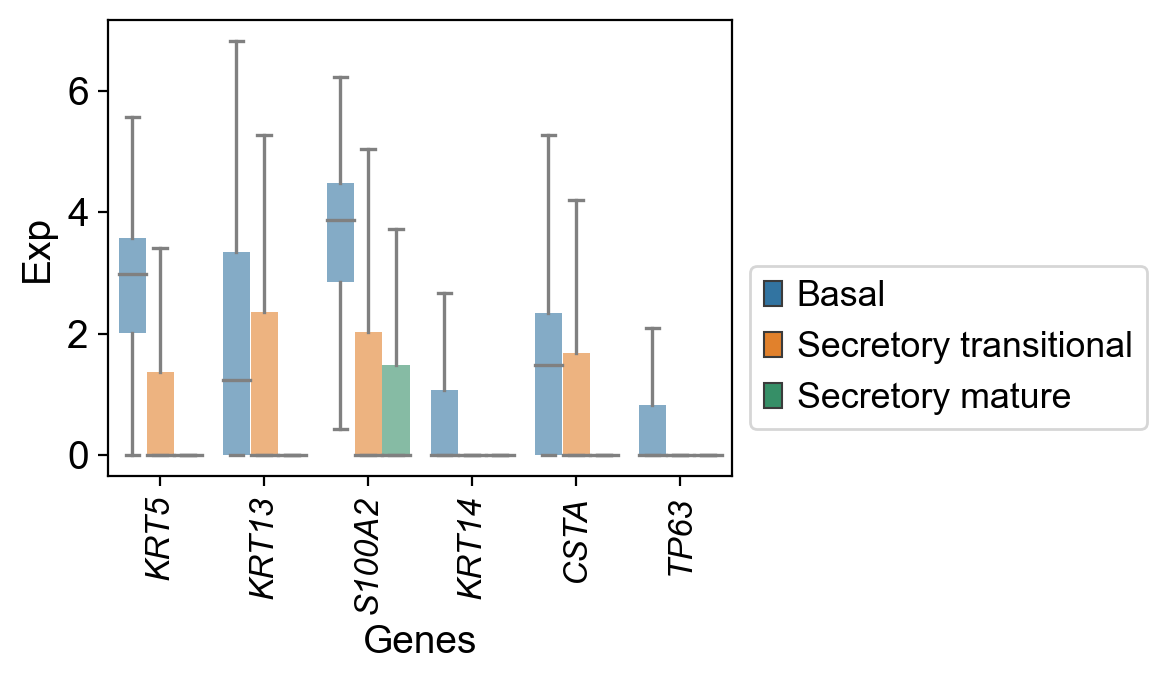

In [30]:
# plot expression:

pl.figure(figsize = (4,3))
sn.boxplot(data = basal_exp_pd, y='Exp', x = 'Genes', hue = 'Cell state', showfliers = False,
          boxprops=dict(alpha=.6, linewidth = 0),
           whiskerprops=dict(linestyle='-', linewidth=1.2, color='grey'),
           capprops=dict(linestyle='-', linewidth=1.2, color='grey'),
            medianprops=dict(linestyle='-', linewidth=1.2, color='grey'))
pl.xticks(rotation = 90,fontstyle = 'italic', fontsize=12)
pl.grid(False)
pl.legend(bbox_to_anchor=(1, 0., 0.5, 0.5))

pl.savefig("../../figures/FigS3D_basal_marker_genes.pdf", bbox_inches='tight', dpi = 300)


## Transitional multiciliated cells:

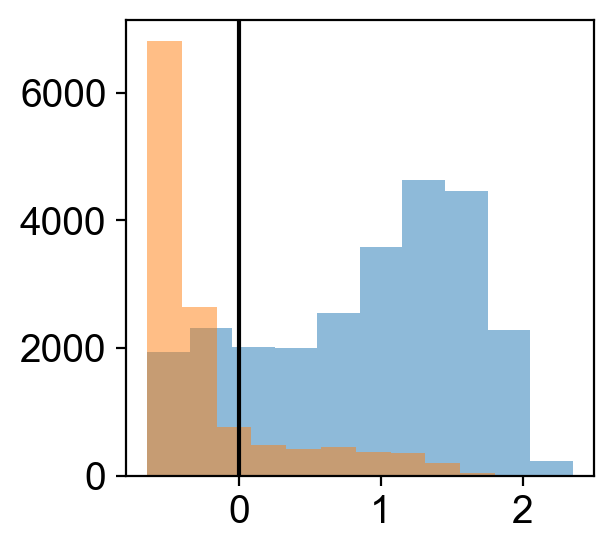

In [31]:
# secretory score in multiciliated cells and secretory score is secretory cells
pl.figure(figsize = (3,3))

pl.hist(z_dict2['Secretory']['Secretory'], alpha = 0.5, rasterized = True)
pl.hist(z_dict2['Multiciliated']['Secretory'], alpha = 0.5, rasterized = True)
pl.grid(False)
pl.axvline(x=0, color = 'black')

pl.savefig("../../figures/FigS3E_revision_sec_score_hist2.pdf", 
           bbox_inches='tight', dpi = 300)



In [32]:
# subset transitional and mature multiciliated cells
ix_mcc_sec= z_dict2['Multiciliated'].loc[z_dict2['Multiciliated']['Secretory'] > 0].index

ix_pure_mcc= np.array(list(set(ix_mcc)-set(ix_mcc_sec)))
ix_pure_mcc.sort()

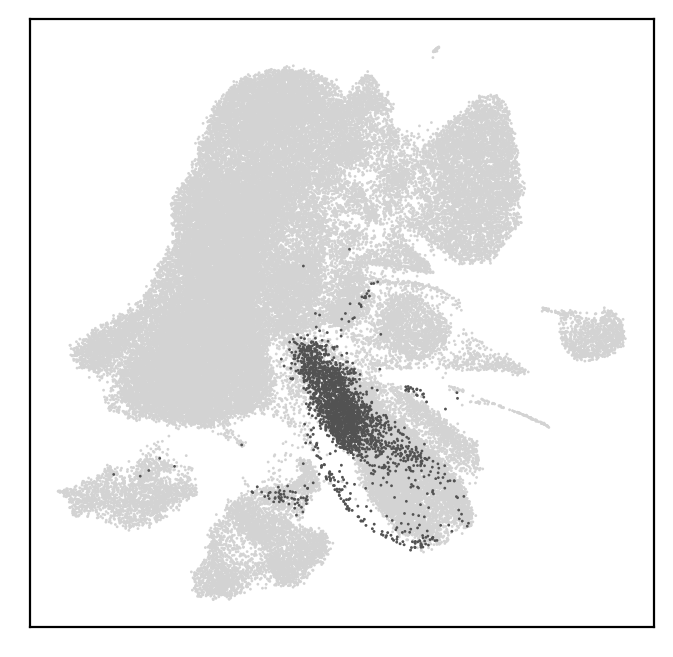

In [33]:
# plot transitional MCCs on UMAP:

umap_mcc_sec = adata[ix_mcc_sec].obsm['X_umap']

pl.scatter(umap_all[:,0], umap_all[:,1],
           color = 'lightgrey', s=1, edgecolor = 'none', rasterized = True)
pl.scatter(umap_mcc_sec[:,0], umap_mcc_sec[:,1], s=1, edgecolor = 'none', 
           color ='#525252',rasterized = True)

pl.xticks([])
pl.yticks([])
pl.savefig("../../figures/FigS3F_revisions_sec-high_mcc_cells2.pdf", 
          bbox_inches='tight', dpi = 300)


In [34]:
# gene expression of secretory genes in sec, mcc-transitional and mcc-mature cells:
adata_temp3 = adata[:,secretory_shortlist].copy()

sec_exp3 = pd.DataFrame([adata_temp3[ix_sec_high].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_sec_high.shape[0], dtype = object) for gene in secretory_shortlist]),
                          'Secretory mature'*np.ones(len(secretory_shortlist)*ix_sec_high.shape[0], dtype = object)])

sec_exp3 = sec_exp3.T

sec_mcc_exp3 = pd.DataFrame([adata_temp3[ix_mcc_sec].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_mcc_sec.shape[0], dtype = object) for gene in secretory_shortlist]),
                          'MCC transitional'*np.ones(len(secretory_shortlist)*ix_mcc_sec.shape[0], dtype = object)])
sec_mcc_exp3 = sec_mcc_exp3.T

pure_mcc_exp3 = pd.DataFrame([adata_temp3[ix_pure_mcc].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_pure_mcc.shape[0], dtype = object) for gene in secretory_shortlist]),
                          'MCC mature'*np.ones(len(secretory_shortlist)*ix_pure_mcc.shape[0], dtype = object)])
pure_mcc_exp3 = pure_mcc_exp3.T

sec_mcc_exp_pd2 = pd.concat([sec_exp3, sec_mcc_exp3, pure_mcc_exp3])
sec_mcc_exp_pd2.columns = ['Exp', 'Genes', 'Cell state']

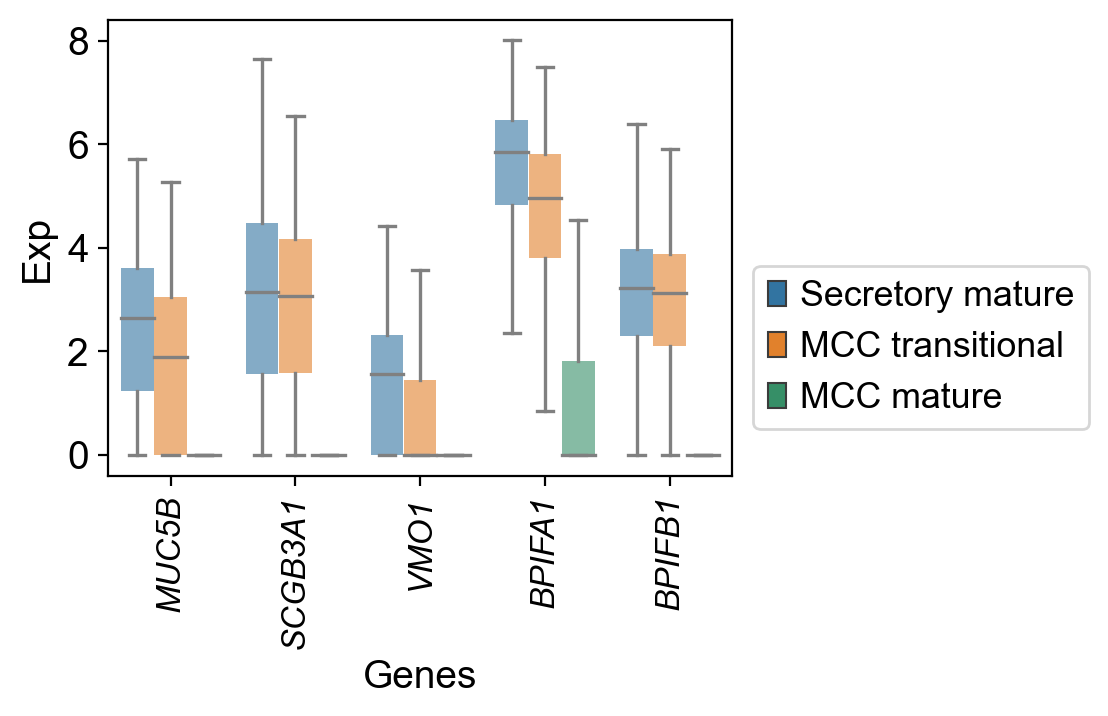

In [35]:
# plot expression:

pl.figure(figsize = (4,3))
sn.boxplot(data = sec_mcc_exp_pd2, y='Exp', x = 'Genes', hue = 'Cell state', showfliers = False,
           boxprops=dict(alpha=.6, linewidth = 0),
           whiskerprops=dict(linestyle='-', linewidth=1.2, color='grey'),
           capprops=dict(linestyle='-', linewidth=1.2, color='grey'),
            medianprops=dict(linestyle='-', linewidth=1.2, color='grey'))
pl.xticks(rotation = 90, fontsize = 12, fontstyle = 'italic')
pl.grid(False)
pl.legend(bbox_to_anchor=(1.1, 0., 0.5, 0.5))

pl.savefig("../../figures/FigS3G_sec_mcc_marker_genes2.pdf", bbox_inches='tight', dpi = 300)


In [36]:
# gene expression of club genes in sec, mcc-transitional and mcc-mature cells:

adata_temp3 = adata[:,multiciliated_shortlist].copy()

sec_exp4 = pd.DataFrame([adata_temp3[ix_sec_high].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_sec_high.shape[0], dtype = object) for gene in multiciliated_shortlist]),
                          'Secretory (Sec-high)'*np.ones(len(multiciliated_shortlist)*ix_sec_high.shape[0], dtype = object)])

sec_exp4 = sec_exp4.T

sec_mcc_exp4 = pd.DataFrame([adata_temp3[ix_mcc_sec].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_mcc_sec.shape[0], dtype = object) for gene in multiciliated_shortlist]),
                          'MCC (Sec-high)'*np.ones(len(multiciliated_shortlist)*ix_mcc_sec.shape[0], dtype = object)])
sec_mcc_exp4 = sec_mcc_exp4.T

pure_mcc_exp4 = pd.DataFrame([adata_temp3[ix_pure_mcc].X.A.flatten(order = 'F'),
                          np.hstack([ gene*np.ones(ix_pure_mcc.shape[0], dtype = object) for gene in multiciliated_shortlist]),
                          'MCC (Sec-low)'*np.ones(len(multiciliated_shortlist)*ix_pure_mcc.shape[0], dtype = object)])
pure_mcc_exp4 = pure_mcc_exp4.T

mcc_exp_pd2 = pd.concat([sec_exp4, sec_mcc_exp4, pure_mcc_exp4])
mcc_exp_pd2.columns = ['Exp', 'Genes', 'Cell state']

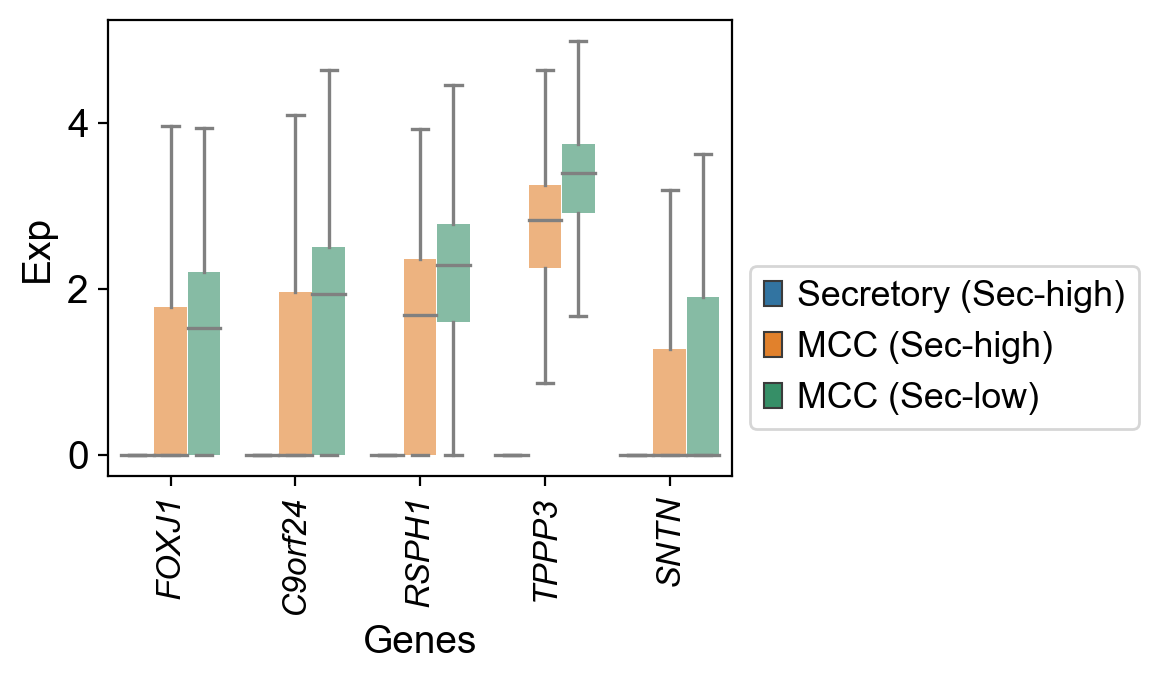

In [37]:
# plot expression:
pl.figure(figsize = (4,3))
sn.boxplot(data = mcc_exp_pd2, y='Exp', x = 'Genes', hue = 'Cell state',
           showfliers = False,
          boxprops=dict(alpha=.6, linewidth = 0),
           whiskerprops=dict(linestyle='-', linewidth=1.2, color='grey'),
           capprops=dict(linestyle='-', linewidth=1.2, color='grey'),
            medianprops=dict(linestyle='-', linewidth=1.2, color='grey'))
pl.xticks(rotation = 90, fontsize = 12, fontstyle = 'italic')
pl.grid(False)
pl.legend(bbox_to_anchor=(1, 0., 0.5, 0.5))

pl.savefig("../../figures/FigS3G_mcc_marker_genes2.pdf", bbox_inches='tight', dpi = 300)


# Plot gene expression heatmap with new order

In [38]:
mcc_sec_hi = z_dict2['Multiciliated'][z_dict2['Multiciliated']['Secretory']>0]
ix_mcc_sec_hi_order = mcc_sec_hi.sort_values(by = 'Multiciliated', ascending = False).index

mcc_sec_lo = z_dict2['Multiciliated'][z_dict2['Multiciliated']['Secretory']<=0]
ix_mcc_sec_lo_order = mcc_sec_lo.sort_values(by = 'Multiciliated', ascending = False).index


In [39]:
sec_hi = z_dict2['Secretory'][z_dict2['Secretory']['Secretory']>0]
ix_sec_hi_order = sec_hi.sort_values(by = 'Secretory', ascending = False).index


In [40]:
exp_markers_ordered3 = pd.concat([exp_markers_dict2['Basal'].loc[ix_basal_order,:], 
                                exp_markers_dict2['Secretory'].loc[ix_secretory_order,:],
                                exp_markers_dict2['Multiciliated'].loc[ix_mcc_sec_lo_order,:],
                                exp_markers_dict2['Multiciliated'].loc[ix_mcc_sec_hi_order,:],
                                  exp_markers_dict2['Rare'].loc[ix_rare_order,:]])

In [41]:
# putting yticks on the heatmap:
# will put ticks at the end of each cell type:

z1 = exp_markers_dict2['Basal'].shape[0]
z2 = z1 + exp_markers_dict2['Secretory'][z_dict2['Secretory']['Secretory']>0].shape[0]
z3 = z2 + exp_markers_dict2['Secretory'][z_dict2['Secretory']['Secretory']<=0].shape[0]
z4 = z3 + exp_markers_dict2['Multiciliated'][z_dict2['Multiciliated']['Secretory']<0].shape[0]
z5 = z4 + exp_markers_dict2['Multiciliated'][z_dict2['Multiciliated']['Secretory']>=0].shape[0]
z6 = z5 + exp_markers_dict2['Rare'].shape[0]

yticks_for_heatmap2 = np.array([z1,z2,z3,z4,z5,z6])
                               
                               
                               

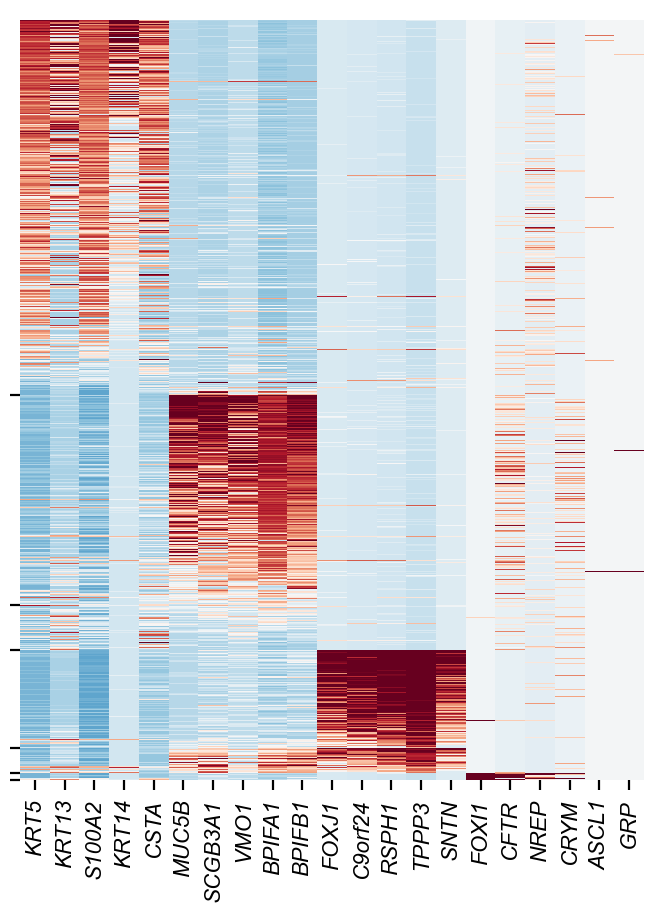

In [42]:
# plot heatmap of marker genes

pl.figure(figsize = (4,5))
sn.heatmap(exp_markers_ordered3, vmax = 2, vmin = -2, cmap = 'RdBu_r',
           xticklabels=markergene_list2, yticklabels=[], cbar = [], rasterized= True)

bli = pl.xticks(fontsize = 8, fontname = 'Arial', style = 'italic')
bla = pl.yticks(yticks_for_heatmap2)

pl.savefig("../../figures/Fig2B_heatmap_marker_genes.pdf", bbox_inches='tight', dpi = 300)


# Save transitional cell states annotations

In [43]:
# mcc:
ix_mcc_sec_hi = ix_mcc_sec_hi_order.sort_values()
ix_mcc_sec_lo = ix_mcc_sec_lo_order.sort_values()

# secretory:
ix_sec_lo = z_dict2['Secretory'][z_dict2['Secretory']['Secretory']<0].index
ix_sec_hi = z_dict2['Secretory'][z_dict2['Secretory']['Secretory']>0].index 


In [44]:
# name these transitional states:
states_fine = cell_states_combined.copy()
states_fine[ix_sec_lo] = 'Secretory-transitional'
states_fine[ix_mcc_sec_lo] = 'Multiciliated-mature'
states_fine[ix_mcc_sec_hi] = 'Multiciliated-transitional'

for i,states in enumerate(states_fine):
    if states == 'Secretory':
        states_fine[i] = 'Secretory-mature'
        

/Users/mcbuser/opt/anaconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


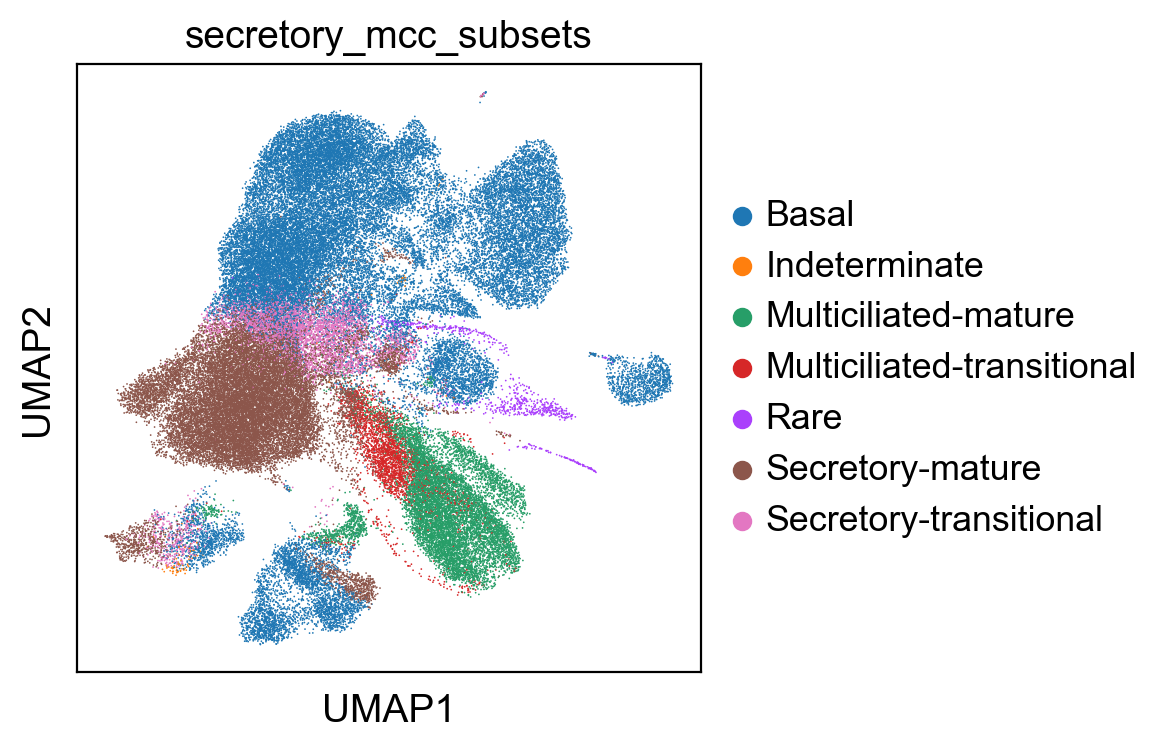

In [45]:
# plot these states:
adata.obs['secretory_mcc_subsets'] = states_fine
sc.pl.umap(adata, color = 'secretory_mcc_subsets')

# Plot total UMI distribution

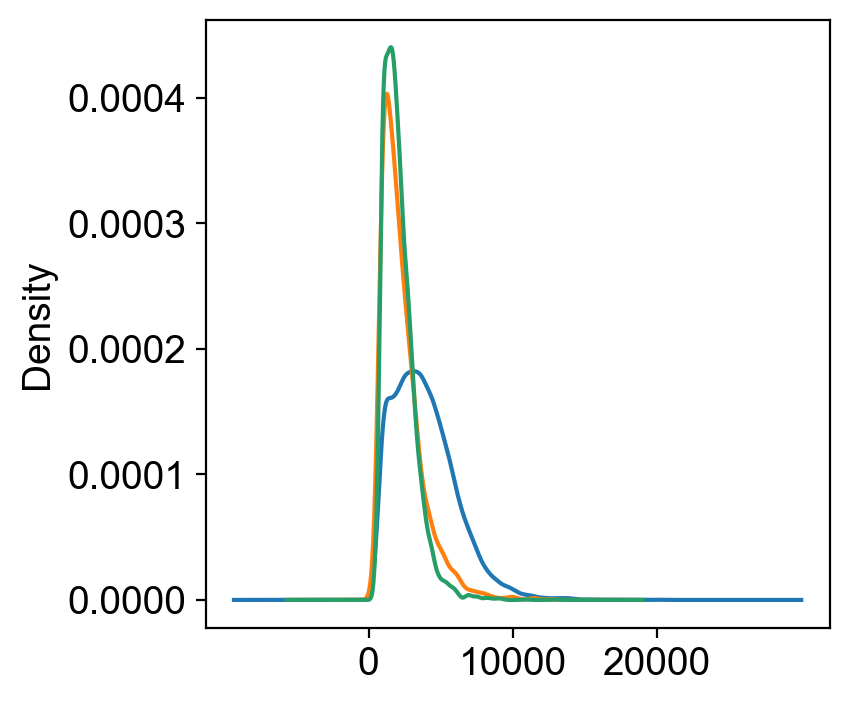

In [46]:
(adata[ix_sec_hi_order].obs.n_counts).plot.density()
(adata[ix_mcc_sec_hi].obs.n_counts).plot.density()
(adata[ix_mcc_sec_lo].obs.n_counts).plot.density()
pl.grid(False)

pl.xticks([0,10000,20000])

pl.savefig("../../figures/FigS3H_umi_dist.pdf", bbox_inches='tight', dpi = 300)

# Heatmap for goblet cells

In [47]:
goblet_il13_markers = ['MUC5AC','SPDEF','CST1','CST4', 'CAMK1']
goblet_il17a_markers = [ 'CSF3', 'FCGBP', 'SLC26A4', 'LCN2','CXCL1']

In [48]:
def gene_exp2(adata, gene_list):
    
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_genes(adata, min_counts=6)
    
    # normalized data:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.layers['raw_counts'] = adata.X.copy()

    # subset adata:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    
    # log transform data:
    sc.pp.log1p(adata)

    # subset adata:
    adata_subset = adata[:,gene_list].copy()

    # scale data
    sc.pp.scale(adata_subset)

    # take mean expression of neighbors
    mean_exp = adata_subset.X[find_knn2(adata)].mean(axis=1)
    mean_exp = pd.DataFrame(mean_exp)
    mean_exp.columns = gene_list

    return mean_exp


In [49]:
def find_knn2(adata, neighbors = 10):
    
    # identify highly variable genes:
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)

    # scale data:
    sc.pp.scale(adata)

    # find top 50 PCs:
    sc.pp.pca(adata, n_comps=50, svd_solver='arpack')
    
    # find nearest neighbors:
    E = adata.obsm['X_pca']

    adata_neigbhors = NearestNeighbors(n_neighbors=neighbors, metric='euclidean').fit(E)
    knn = adata_neigbhors.kneighbors(E)[1]
    
    return knn


In [50]:
gene_exp_goblet = gene_exp2(adata, ['MUC5B']+goblet_il13_markers+goblet_il17a_markers)


filtered out 6937 genes that are detected in less than 3 cells
filtered out 2704 genes that are detected in less than 6 counts
normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:13)


In [51]:
goblet_mask = np.array(adata.obs.cell_states == 'Goblet')
ctrl_mask = np.array(adata.obs.condition == 'None')
il13_mask = np.array(adata.obs.condition == 'IL13')
il17_mask = np.array(adata.obs.condition == 'IL17A')



In [52]:
goblet_heatmap = pd.concat([gene_exp_goblet[il13_mask*goblet_mask].sort_values(by = 'MUC5AC'),
                            gene_exp_goblet[il17_mask*goblet_mask].sort_values(by = 'MUC5AC'),
                            gene_exp_goblet[ctrl_mask*goblet_mask].sort_values(by = 'MUC5AC')])

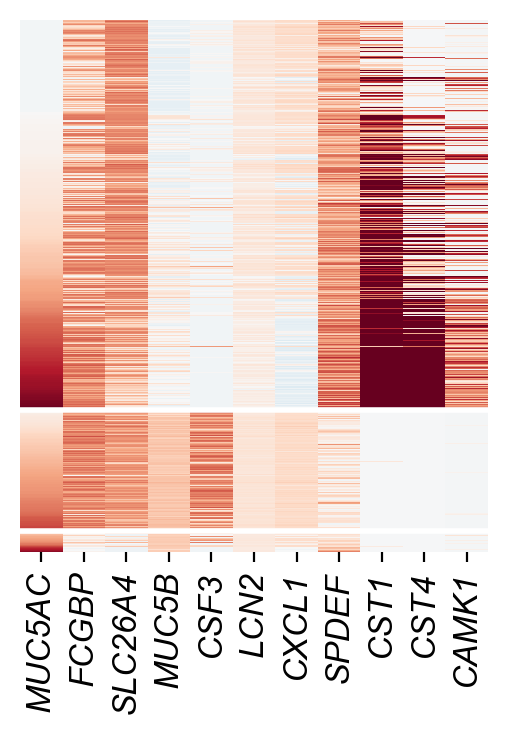

In [53]:
goblet_gene_order = ['MUC5AC', 'FCGBP','SLC26A4','MUC5B', 'CSF3',  'LCN2', 'CXCL1','SPDEF', 'CST1', 'CST4', 
                          'CAMK1' ]
pl.figure(figsize = (3,3.5))
sn.heatmap(goblet_heatmap[goblet_gene_order],
           cmap = 'RdBu_r',rasterized= True, vmin = -7, vmax = 7, cbar= False)
pl.yticks([])
pl.xticks(fontsize=12)
bla = pl.xticks(style = 'italic', fontname = 'Arial')
pl.axhline(y=754, color='white',linewidth= 2 )
pl.axhline(y=989, color='white',linewidth= 2 )

pl.savefig("../../figures/Fig2K_revisions_heatmap_goblet.pdf", bbox_inches='tight', dpi = 300)


In [54]:
il13_avg_exp = gene_exp_goblet[il13_mask*goblet_mask].sort_values(by = 'MUC5AC').mean()
il17_avg_exp = gene_exp_goblet[il17_mask*goblet_mask].sort_values(by = 'MUC5AC').mean()
ctrl_avg_exp = gene_exp_goblet[ctrl_mask*goblet_mask].sort_values(by = 'MUC5AC').mean()

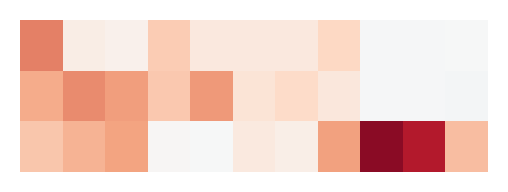

In [55]:
pl.figure(figsize = (3,1))

sn.heatmap(pd.DataFrame([ctrl_avg_exp,il17_avg_exp,il13_avg_exp])[goblet_gene_order],
           cmap = 'RdBu_r',rasterized= True,vmin = -7, vmax = 7, cbar= False)
pl.yticks([])
pl.xticks([])
pl.savefig("../../figures/Fig2K_revisions_avg_heatmap_goblet.pdf", bbox_inches='tight', dpi = 300)
